In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


from sources.model import BeliefAutoencoder, gumbel_softmax
from sources.preprocessing import preprocessing, preprocess_sentence

def set_seed(seed=20190827):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed()

preprocessed_data = preprocessing("data/dataset_sentence_level.csv", device='cpu')
vocab = preprocessed_data.vocab
model = BeliefAutoencoder(emb_dim=64, h_dim=128, latent_dim=32, vocab=vocab, categorical_dim=1)

#model.load_state_dict(torch.load("models/belief-autoencoder-bc-YP68fCFu.pth", map_location='cpu'))
model.load_state_dict(torch.load("models/belief-autoencoder-dnGrTTMp.pth", map_location='cpu'))
model.eval()

23110


BeliefAutoencoder(
  (drop): Dropout(p=0.0, inplace=False)
  (embedding): Embedding(1450, 64, padding_idx=0)
  (lstm_encoder): GRU(64, 128, batch_first=True, bidirectional=True)
  (sampling_input): Linear(in_features=256, out_features=32, bias=True)
  (z_embedding): Linear(in_features=32, out_features=64, bias=True)
  (lstm_decoder): GRU(64, 128, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=1450, bias=True)
)

In [8]:
sentences = ["you have an apple in your inventory", "apple"]
seq_lens = [len(s.split()) for s in sentences]
max_len = max(seq_lens)
vectorized = []
for s in sentences:
    idxs, tgt, seq_len = preprocess_sentence(s, vocab, max_len)
    vectorized.append(idxs)
tensorized = torch.tensor(vectorized)

seq_len = torch.tensor(seq_lens)
tensorized

tensor([[  1,   3,   4,  18, 156,  15,  16,  17,   0],
        [  1, 156,   0,   0,   0,   0,   0,   0,   0]])

In [9]:
with torch.no_grad():
    y_hat, qy, _ = model(x=tensorized, seq_len=seq_len, temperature=1e-20)
#qy = gumbel_softmax(qy, temperature=1e-20,latent_dim=30, categorical_dim=2, hard=True)
qy = F.sigmoid(qy)
torch.round(qy).squeeze(-1)

/home/ichida/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
         1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
         1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.]])

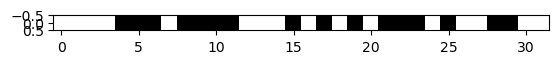

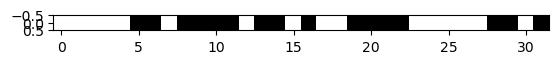

In [10]:
latent = torch.round(qy).squeeze(-1)
latent = latent.view(2, 1, 32)
latent_vectors = latent.detach().cpu().numpy()
for vector in latent_vectors:
    plt.figure()
    plt.imshow(vector, cmap='gray')
    plt.show()

In [11]:
inverted_vocab = {idx: word for word, idx in vocab.items()}

y_hat.argmax(dim=-1)
idxs = y_hat.argmax(dim=-1).detach().cpu().numpy()
for idx in idxs:
    print([inverted_vocab[i] for i in idx])
    print(idx)

['a', 'have', 'a', 'orange', 'in', 'your', 'inventory', '<EOS>', '<EOS>']
[ 5  4  5 48 15 16 17  2  2]
['a', 'juice', 'reproducing', 'and', '<EOS>', 'now', 'in', 'the', 'to']
[  5 578  57  61   2 114  15  10  77]


In [77]:
next_word = torch.tensor([vocab['<SOS>']])
z_emb = model.z_embedding(qy[0,:,:].view(1, 60)).unsqueeze(0)  # z_emb será usado como h inicial do LSTM decoder

_, batch_size, hidden_len = z_emb.size()
hidden = z_emb.view(2, 1, int(hidden_len / 2))  # h_t
sentence = []
next_word = next_word.unsqueeze(0)
print(hidden.size(), next_word.size())
for i in range(max_len):
    sentence.append(next_word)
    next_word_emb = model.embedding(next_word)
    x, hidden = model.lstm_decoder(next_word_emb, hidden)
    #x, _ = pad_packed_sequence(x)
    x = model.output_layer(x)
    next_word = x.argmax(dim=-1)
s = torch.cat(sentence)
s

torch.Size([2, 1, 300]) torch.Size([1, 1])


tensor([[  1],
        [  0],
        [  0],
        [  0],
        [119],
        [  0],
        [  0]])

In [78]:
[inverted_vocab[i] for i in s.squeeze(-1).detach().numpy().tolist()]

['<SOS>', '<PAD>', '<PAD>', '<PAD>', '3', '<PAD>', '<PAD>']

In [76]:
qy[0,:,:], qy[1,:,:]

(tensor([[8.2806e-04, 9.9941e-01],
         [6.5952e-01, 3.7537e-01],
         [1.3543e-02, 9.8676e-01],
         [7.6780e-02, 9.3148e-01],
         [9.9985e-01, 1.1610e-04],
         [9.9946e-01, 2.8733e-04],
         [9.9685e-01, 6.6426e-03],
         [9.9788e-01, 5.5238e-03],
         [9.9924e-01, 6.1472e-04],
         [9.9751e-05, 9.9984e-01],
         [7.9383e-07, 1.0000e+00],
         [2.1500e-01, 7.1328e-01],
         [9.1362e-03, 9.8036e-01],
         [8.4709e-06, 9.9998e-01],
         [9.5656e-01, 5.3405e-02],
         [2.4508e-02, 9.5849e-01],
         [1.8293e-02, 9.8606e-01],
         [9.7044e-01, 1.9000e-02],
         [8.6453e-02, 8.4050e-01],
         [9.9999e-01, 1.7152e-05],
         [4.0549e-02, 9.8730e-01],
         [1.0000e+00, 3.3609e-07],
         [1.2495e-02, 9.7839e-01],
         [2.1059e-01, 7.9157e-01],
         [3.6606e-05, 9.9985e-01],
         [1.0368e-04, 9.9987e-01],
         [8.2068e-03, 9.9318e-01],
         [1.0000e+00, 5.1429e-07],
         [1.1812e-06